# Feature Selection

This user guide details how dnamite can be used for feature selection / feature-sparse prediction.

### Why Bother with Feature Selection?

When training a black-box machine learning model, it is common practice to use all available features even for high-dimensional datasets, as modern ML models can easily handle many features. However, there are some settings where feature selection is very useful:

1) **Interpretability**: When training a glass-box model, we need to care about both predictive performance as well as accurate and utility of explanations. While glass-box models often have good accurate on high-dimensional datasets, model explanations are much more likely to be impaired in such settings. In particular, when sets of correlated features are all used in the same dataset, additive models run into identifiability issues with how to spread contribution across the feature set. This tends to cause increased variance in feature importances and shape functions, reducing confidence in the model's interpretations.

2) **Simplicity**: Models that use less features are inherently simpler models, which can help with both interpretability and generalizability. For example, consider a model used to predict cancer risk which uses hundreds of features. This model is harder to explain completely doctors and patients since even a glass-box model requires hundreds of shape function plots to describe completely. Also, if the model is deployed to a different medical network than is used during training, it's likely that several features are not available at the new medical network which increases missing values and thus decreases predictive performance.

3) **Extreme High-Dimensionality**: In datasets that are extremely high-dimensional (e.g. more features than samples), feature selection can be beneficial even just for improving predictive accuracy along with the above reasons. One common example is genomic datasets where samples are expensive to collect but each sample can many thousands of features on the expression level of various genes. 

### Example

To showcase the capabilities of DNAMite for feature selection, we'll use the [Ames housing dataset](https://www.openml.org/search?type=data&status=active&id=42165). This dataset involves predicting house prices in Ames, Iowa, similar to the California housing dataset. Different than the California housing data, though, the Ames housing dataset contains a larger number of features, some of which are categorical, along with missing values. We'll demonstrate how dnamite can be used to fit a low-dimensional interpretable model to this dataset.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"

housing = fetch_openml(name="house_prices", as_frame=True, parser='auto')
data = housing["frame"]
X = data.drop(["Id", "SalePrice"], axis=1)
y = data["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
print("Dataset shape", X.shape)

Dataset shape (1460, 79)


We start by fitting a model to the complete dataset to serve as a performance benchmark. We set a few additional optional parameters to account for the fact that the Ames dataset has a smaller number of rows.

In [6]:
from dnamite.models import DNAMiteRegressor

model = DNAMiteRegressor(
    random_state=0,
    device=device,
)
model.fit(X_train, y_train)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score
preds = model.predict(X_test)
print("DNAMite RMSE:", mean_squared_error(y_test, preds, squared=False))

DNAMite RMSE: 26555.21610185763


The model achieves reasonably good test RMSE. Now let's look at the model's feature importances and shape functions.

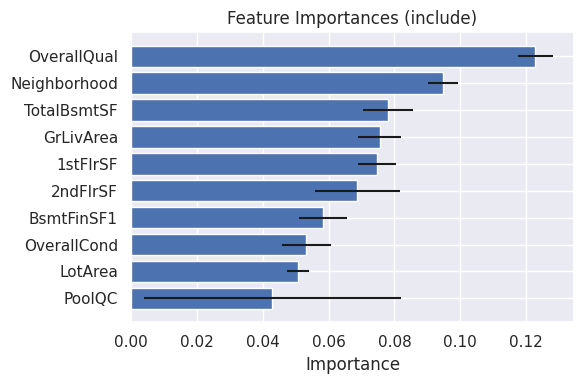

In [8]:
model.plot_feature_importances()

The most important feature is the overall quality of the house, while several features relative to the house's square footage are also important. 

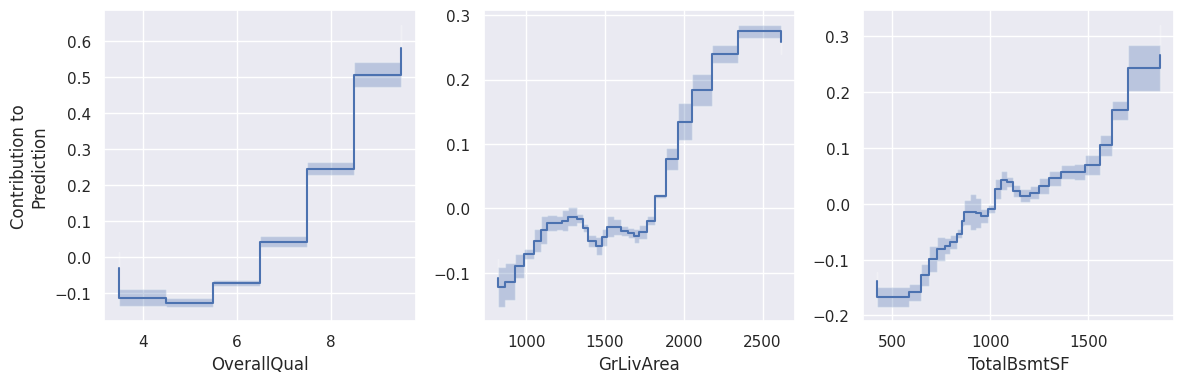

In [10]:
model.plot_shape_function([
    "OverallQual",
    "GrLivArea",
    "TotalBsmtSF",
])

These shape functions reveal expected trends, as higher quality and larger houses are generally more expensive.

Now, let's see how the model changes if we do feature selection. We start by using the `select_features(...)` function to select a set of features from the full dataset. The parameter `reg_param` controls the strength of the feature regularization, with larger values resulting in less features.

In [12]:
model_sparse = DNAMiteRegressor(
    device=device, 
    random_state=0,
)
model_sparse.select_features(
    X_train,
    y_train,
    reg_param=0.02
)
print("Number of Selected Features:", len(model_sparse.selected_feats))
print("List of Selected Features")
model_sparse.selected_feats

Number of Selected Features: 11
List of Selected Features


['LotArea',
 'Neighborhood',
 'BldgType',
 'OverallQual',
 'YearRemodAdd',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'OpenPorchSF']

The model selects several of the top features from the original model. Now we can train an evaluate a model on the selected features using the same functions as before, and dnamite will automatically use the selected features.

In [13]:
model_sparse.fit(X_train, y_train)

[WARNING] Found selected features. Using only those features.


In [15]:
from sklearn.metrics import mean_squared_error
preds = model_sparse.predict(X_test)
print("Sparse model RMSE:", mean_squared_error(y_test, preds, squared=False))
print("Full model RMSE:", mean_squared_error(y_test, model.predict(X_test), squared=False))

Sparse model RMSE: 28264.213762874733
Full model RMSE: 26555.21610185763


The RMSE of this model is only about $1800 worse than the first model despite only using 11 features. Now we can see how the feature importances change.

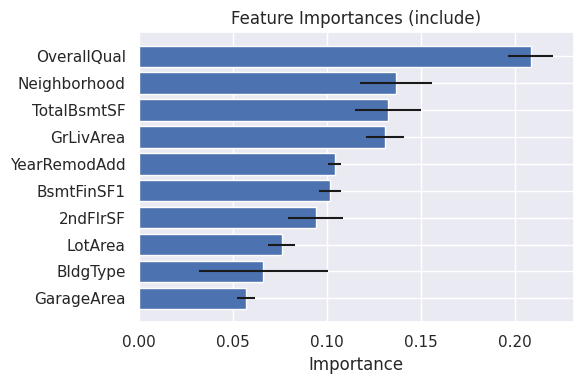

In [16]:
model_sparse.plot_feature_importances()

One notable difference is several of the top features have higher importance scores in the sparse model. One explanation is that the signal from the unselected features has shifted into the more important features in the sparse model, highlighting the redundancy of the pruned features.

### Implementation Details

dnamite does feature selection using the differential binary gates method first introduced in [1]. When doing feature selection, Ddnamite fits an additive model of the form (ignoring interactions for simplicity) $$ f(X) = \sum_j f_j(X_j) s(\mu_j) $$ where $s(\mu_j)$ is the *smooth-step function* with learnable parameter $\mu_j$: 
$$ 
s(\mu; \gamma)
\begin{cases}
    0 & \text{if } \mu \leq -\gamma/2 \\
    -\frac{2}{\gamma^3}\mu^3 + \frac{3}{2\gamma}\mu + \frac{1}{2} & \text{if } -\gamma/2 \leq \mu \leq \gamma/2 \\
    1 & \text{if } \mu \geq \gamma/2
\end{cases}.
$$
During training, if $\mu_j$ is updated such that $s(\mu_j) = 0$, then feature $j$ no longer impact the model and thus can be pruned.
In order to encourage sparsity during training, dnamite uses a sparsity regularizer encourages the $s(\mu_j)$'s to be small: $$L_S = \lambda \sum_j s(\mu_j).$$ 
For further details on how dnamite does feature selection, see [2].

[1] Ibrahim, Shibal, et al. "GRAND-SLAMIN’Interpretable Additive Modeling with Structural Constraints." Advances in Neural Information Processing Systems 36 (2024).

[2] Van Ness, Mike, and Madeleine Udell. "Interpretable Prediction and Feature Selection for Survival Analysis." arXiv preprint arXiv:2404.14689 (2024).

### Hyperparameters


dnamite has multiple hyperparameters that can be set to control feature selection. The below parameters are optional parameters for the `select_features` function the controls feature selection.

- `reg_param`: controls the strength of feature selection. It is equivalent to $\lambda$ in the sparsity regularizer $L_S$ above. 
- `select_pairs`: whether or not pairs are selected using feature selection.
- `pair_reg_param`: similar to `reg_param` except it controls the strength of feature selection for interactions opposed to main features. Since interactions are chosen and pruned after main feature selection, this parameter often can be set to a smaller value than `reg_param`. 
- `gamma`: controls how quickly the smooth-step functions $s(\mu_j)$ reach 0 and 1. A smaller value of `gamma` will result in features being pruned earlier in training, while a larger value will cause features to be pruned later in training. The default value is `gamma = 1`, but in our experience a smaller value is often needed for smaller datasets.
- `pair_gamma`: equivalent to `gamma` but for pairs.
- `entropy_param`: equivalent to $\tau$ in the entropy regularizer $L_E$ above. Similar to `gamma`, different values of `entropy_param` impact how quickly features are pruned during training. Higher values of `entropy_param` will cause features/interactions to be pruned faster. The default of `entropy_param = 0.001` is usually a good starting point.